<a href="https://colab.research.google.com/github/vlrhsgody/DeepLearning/blob/main/DL_FCN_8s_Semantic_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random

In [6]:
import os
import cv2
import random
import shutil
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

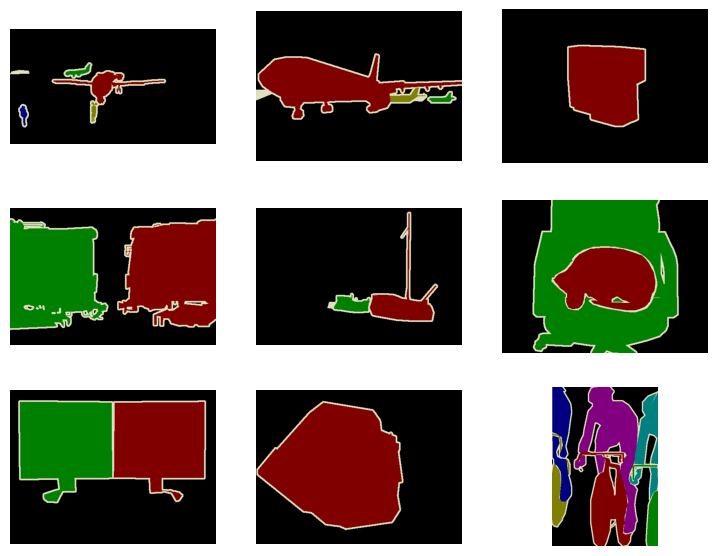

In [7]:
paths=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/VOC2007/SegmentationObject'):
    for filename in filenames:
        paths+=[(os.path.join(dirname, filename))]
paths.sort()
fig, axs = plt.subplots(3,3,figsize=(9,7))
for i in range(9):
    r=i//3
    c=i%3
    img = plt.imread(paths[i])
    ax=axs[r][c].axis("off")
    ax=axs[r][c].imshow(img)
plt.show()

In [13]:
def load_voc2007_data(base_path):
    image_paths = []
    mask_paths = []
    for dirname, _, filenames in os.walk(os.path.join(base_path, 'JPEGImages')):
        for filename in filenames:
            if filename.endswith('.jpg'):
                image_paths.append(os.path.join(dirname, filename))
                mask_path = os.path.join(base_path, 'SegmentationClass', filename.replace('.jpg', '.png'))
                if os.path.exists(mask_path):
                    mask_paths.append(mask_path)
                else:
                    mask_paths.append(None)

    valid_image_paths = []
    valid_mask_paths = []

    for image_path, mask_path in zip(image_paths, mask_paths):
        if mask_path:
            valid_image_paths.append(image_path)
            valid_mask_paths.append(mask_path)

    return valid_image_paths, valid_mask_paths

def preprocess_image(image_path, mask_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, [224, 224], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    mask = tf.cast(mask, tf.int32)

    return image, mask

base_path = '/content/drive/MyDrive/VOC2007'
image_paths, mask_paths = load_voc2007_data(base_path)
dataset = tf.data.Dataset.from_tensor_slices((image_paths, mask_paths))
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [14]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 224, 224, 1), dtype=tf.int32, name=None))>

In [15]:
def fcn_8s_model(num_classes):
    base_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False)
    pool3 = base_model.get_layer('block3_pool').output
    pool4 = base_model.get_layer('block4_pool').output
    pool5 = base_model.get_layer('block5_pool').output

    x = tf.keras.layers.Conv2D(4096, (7, 7), activation='relu', padding='same')(pool5)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(x)
    x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)

    pool4 = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(pool4)
    x = tf.keras.layers.Add()([x, pool4])
    x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size=(4, 4), strides=(2, 2), padding='same')(x)

    pool3 = tf.keras.layers.Conv2D(num_classes, (1, 1), padding='same')(pool3)
    x = tf.keras.layers.Add()([x, pool3])
    x = tf.keras.layers.Conv2DTranspose(num_classes, kernel_size=(16, 16), strides=(8, 8), padding='same')(x)

    output = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs=base_model.input, outputs=output)

    return model

num_classes = 21  # VOC2007 데이터셋의 클래스 수
model = fcn_8s_model(num_classes)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


58889256/58889256 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, 224, 224, 64)         36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)         0         ['block1_conv2[0][0]']        
                             

In [16]:
model.fit(dataset, epochs=10)


Epoch 1/10
14/14 [==============================] - 290s 18s/step - loss: nan - accuracy: 0.6435
Epoch 2/10
14/14 [==============================] - 13s 883ms/step - loss: nan - accuracy: 0.6929
Epoch 3/10
14/14 [==============================] - 13s 886ms/step - loss: nan - accuracy: 0.6929
Epoch 4/10
14/14 [==============================] - 13s 883ms/step - loss: nan - accuracy: 0.6929
Epoch 5/10
14/14 [==============================] - 12s 869ms/step - loss: nan - accuracy: 0.6929
Epoch 6/10
14/14 [==============================] - 12s 866ms/step - loss: nan - accuracy: 0.6929
Epoch 7/10
14/14 [==============================] - 13s 883ms/step - loss: nan - accuracy: 0.6929
Epoch 8/10
14/14 [==============================] - 13s 875ms/step - loss: nan - accuracy: 0.6929
Epoch 9/10
14/14 [==============================] - 13s 871ms/step - loss: nan - accuracy: 0.6929
Epoch 10/10
14/14 [==============================] - 13s 874ms/step - loss: nan - accuracy: 0.6929


1/1 [==============================] - 2s 2s/step


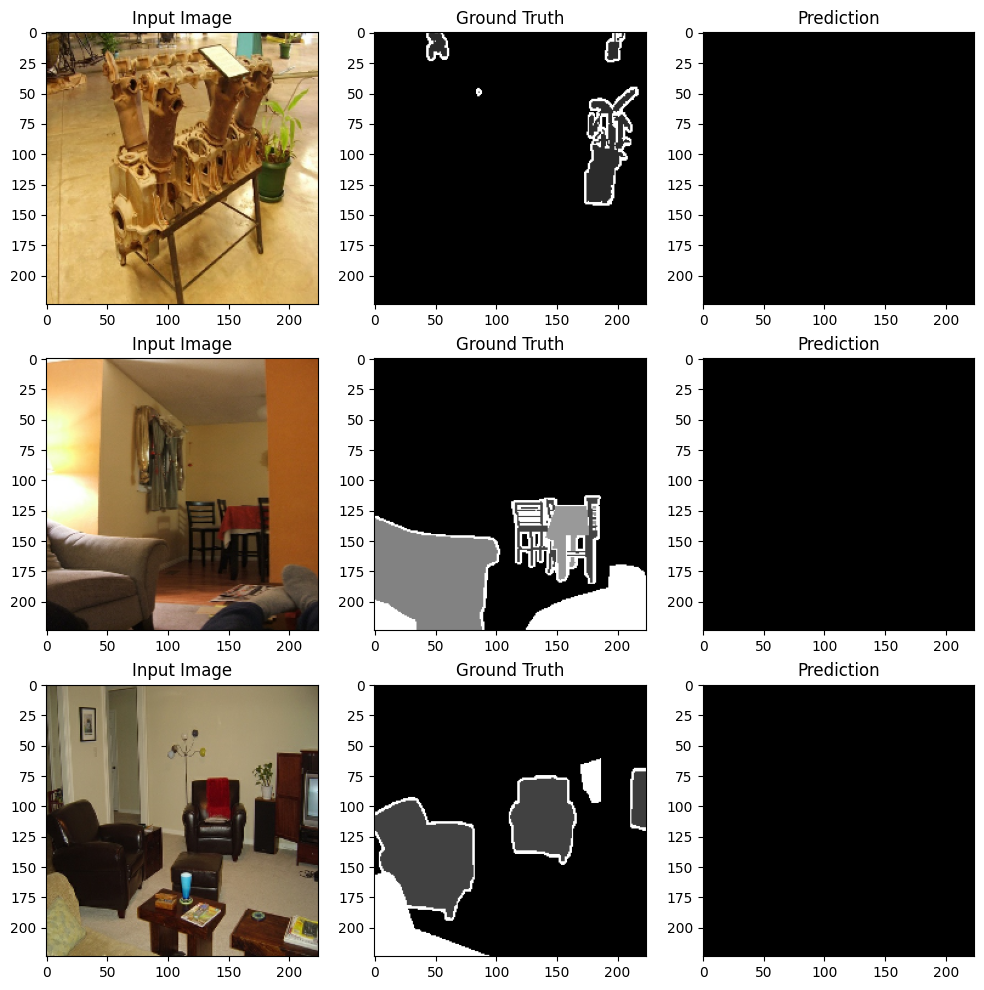

In [17]:
def visualize_predictions(model, dataset):
    for images, masks in dataset.take(1):
        predictions = model.predict(images)
        predictions = tf.argmax(predictions, axis=-1)
        predictions = predictions[..., tf.newaxis]

        fig, axs = plt.subplots(3, 3, figsize=(12, 12))
        for i in range(3):
            axs[i, 0].imshow(images[i].numpy())
            axs[i, 0].set_title('Input Image')
            axs[i, 1].imshow(masks[i].numpy().squeeze(), cmap='gray')
            axs[i, 1].set_title('Ground Truth')
            axs[i, 2].imshow(predictions[i].numpy().squeeze(), cmap='gray')
            axs[i, 2].set_title('Prediction')

        plt.show()

visualize_predictions(model, dataset)
